# Marker gene heatmap of perturbation data - for Fig 6E

In [1]:
%matplotlib inline

import os
import scanpy as sc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

<div class="alert alert-info">
    
# Navigating this notebook
*** ***
**[Input/Output, Settings, and Upload Data](#in_out)**
0. [Directories](#step0)
1. [Plotting parameters](#plot_params)
2. [Load data](#load_data)
    <br>
    <br>

**[Heatmap](#heatmap_logic)**
3. [Parameters for marker gene visualization](#mg_params)
4. [Choose data and annotation levels (PLEASE READ)](#ann_level)
5. [Identify marker genes and order them by state](#id_mg_order)
6. [Gene filtering](#gene_filt)
7. [Save stretch-response genes](#ss_genes)
8. [Prepare final heatmap - marker genes on any set of annotations](#prep_heatmap)
9. [Plot and save files](#plot_save)
    
</div>  

*** ***

<a id='in_out'></a>

## Input/Output & Upload Data

<a id='step0'></a>

### Directories for input and output data

In [2]:
# for AnnData objects from Scanpy:
# These AnnData objects contain output from the filtering and QC notebook
# Containing unnormalized counts matrices with low-count barcodes removed
h5ad_dir = '_h5ad_files'
os.makedirs(h5ad_dir, exist_ok=True)

# for plots from matplotlib, seaborn, helper functions plots:
plot_dir = '_plots_heatmap'
os.makedirs(plot_dir, exist_ok=True)

<a id='plot_params'></a>

### Plotting parameters

In [3]:
# matplotlib params:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rc('font', size=12)
plt.rcParams['pdf.fonttype'] = 42

# scanpy settings:
sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=150)  # low dpi (dots per inch) yields small inline figure

# seaborn
sns.set(context='notebook', style='white', font_scale=1.8)

<a id='load_data'></a>

### Load data

In [4]:
# load data
adata = sc.read(f'{h5ad_dir}/adata_merged_annotated_perturbations.h5ad')

In [5]:
with open('all_genes_post_filter_perturbation', 'w') as f:
    for gene in list(adata.var_names):
        f.write("%s\n" % gene)

In [6]:
len(list(adata.var.loc[adata.var['highly_variable'] == True].index))

4513

In [7]:
with open('highly_variable_genes_perturbation', 'w') as f:
    for gene in list(adata.var.loc[adata.var['highly_variable'] == True].index):
        f.write("%s\n" % gene)

*** ***

<a id='heatmap_logic'></a>

## Code to make a heatmap of marker genes for single cell annotations / clusters

### Overall logic:

* We may wish to identify marker genes on one level of annotations (A1), but visualize them on another level of annotations (A2)
* We'll select genes if they have max expression in A1 annotations, ranked by max-to-second-max ratio
* We'll filter genes to have no more than N markers per annotation, *and* to have no less than max-to-second-max ratio R
* We will then plot them on A1 annotations
* We will then separately plot them on A2 annotations


<a id='mg_params'></a>

### Parameters for marker gene visualization

In [8]:
# Pseudocount value to use below for log-FC and max:2nd-max ratio
pseudocount = 1 # in units of CP10K

# Minimal acceptable max-2nd-max ratio:
max_2ndmax_ratio_thresh = 1.3

# Maximum number marker genes per state:
max_marker_genes = 150

# False discovery rate for p-value filter:
fdr = 0.05

# How to order the genes:
#gene_order_method = 'max_2ndmax_ratio'
gene_order_method = 'max_median_ratio'

<a id='ann_level'></a>

### Choose data and annotation levels (PLEASE READ)

* In the following, rename your scanpy frame to 'adata'
* In the following 'state' contains the annotation that is used for marker gene detection
* In the place clearly marked under 'final visualization', 'state' and  are used for 

**If you wish to change the annotation column and final columns used for visualization, edit the appropriate text below**

In [9]:
# Give a clean name to the data:
adata.obs['state'] = adata.obs['state_coarse_grain']

# Here are the cluster annotations for which we'll identify marker genes:
print(adata.obs['state'].unique())

[Stretch Signature, Secretory, Enterocyte, Tuft, Stem, Enteroendocrine]
Categories (6, object): [Stretch Signature, Secretory, Enterocyte, Tuft, Stem, Enteroendocrine]


<a id='id_mg_order'></a>

### Identify marker genes and order them by state

*Currently, the ordering of states is not explicitly established - you get what Python gives you*

In [10]:
# Make a dataframe containing centroids:
centroids_df = pd.DataFrame(index=list(adata.raw.var_names))
for state in adata.obs['state'].unique():
    tmp = adata.raw[(adata.obs['state'] == state), : ].X.todense().sum(axis=0)
    centroids_df[state]= np.array(tmp).squeeze()

#normalize centroids to CP10K
for col in centroids_df.columns:
    centroids_df[col] = centroids_df[col]/centroids_df[col].sum()*1e4


In [11]:
# filtered in this filename refers to the fact that 29603 genes are represented - those genes that 
# were included post-filtering steps in the processing notebook
centroids_df.to_excel(f'{plot_dir}/centroids_perturbation_data_filtered_genes.xlsx')

<a id='gene_filt'></a>

### Gene filtering

#### Prepare information for gene filtering

In [12]:
# Rank-sum test on genes
# The p-values from these ranks will be used below as a filtering criteria
# We make no other usage of this function
if False:
    sc.tl.rank_genes_groups(adata, groupby='state', method='wilcoxon')

In [13]:
#create a dataframe with information used for filtering and normalization
centroids_info_df = pd.DataFrame()


# the cluster identity in which the gene is maximally expressed
centroids_info_df['max_state'] = centroids_df.idxmax(axis=1)

# the adjusted p-value for the gene in the max cluster 
centroids_info_df['pvals_adj'] = np.ones(np.shape(centroids_info_df['max_state']))
#for state in centroids_df.columns.unique():
    #centroids_info_df.loc[centroids_info_df['max_state'] == state, 'pvals_adj'] = \
        #adata.uns['rank_genes_groups']['pvals_adj'][state][centroids_info_df['max_state'] == state]
    #print(centroids_info_df.loc[centroids_info_df['max_state'] == state, 'pvals_adj'])
    #print(' ')

# the value of max expression, second max expression, and their ratio (pseudo-count corrected)
# NOTE: SECOND-MAX CALCULATION IS SLOW
centroids_info_df['max_CP10K'] = centroids_df.max(axis=1)
centroids_info_df['sec_max_CP10K'] = centroids_df.apply(lambda row: row.nlargest(2).values[-1], axis=1)
centroids_info_df['max_2nd_ratio'] = (pseudocount + centroids_info_df['max_CP10K']) / \
                                            (pseudocount + centroids_info_df['sec_max_CP10K'])

# Rank genes by their max-to-second-max ratio:
centroids_info_df['max_ratio_rank'] = centroids_info_df['max_2nd_ratio'].rank(ascending=False)

# for plotting - the cluster centroid median value per gene
centroids_info_df['med_CP10K'] = centroids_df.median(axis=1)

# max-median ratio:
centroids_info_df['max_med_ratio'] = (pseudocount+ centroids_info_df['max_CP10K']) / \
                                        (pseudocount+ centroids_info_df['med_CP10K'])


#### Apply filtering criteria

In [14]:
# CURRENTLY NOT DOING P-VALUE FILTERING, BECAUSE THE P-VALUES I HAVE FROM THE SCANPY PACKAGE
# SEEM TO MAKE NO SENSE

# Mask out genes that fail p-value test, by hiding their max-cluster assignment
# The masked-out max-state is stored in a new column, max_state_filt

centroids_info_df['max_state_filt'] = centroids_info_df['max_state']
#centroids_info_df.loc[ centroids_info_df['pvals_adj'] > fdr ,'max_state_filt'] = \
#    'non-significant'

In [15]:
# Apply remaining filter criteria to generate gene list
# Gene is max in the cluster
# Gene max-to-2nd-max is above threshold
# No more than max_marker_genes genes

marker_genes_dict = {}
marker_genes_all = []

for state in adata.obs['state'].unique():
    # List of genes that are maximal in the state:
    gl = centroids_info_df.index[(centroids_info_df['max_state_filt']==state)]
    
    # Get the top max_marker_genes from this list, ranked by max-to-second max
    # Using code from https://stackoverflow.com/questions/5807047/efficient-way-to-take-the-minimum-maximum-n-values-and-indices-from-a-matrix-usi
    # First get the lowest values for max_ratio_rank:
    n=len(centroids_info_df['max_ratio_rank'].loc[gl]) # number of genes significantly enriched and max in cluster
    if n > max_marker_genes:
        n=max_marker_genes        
    indices = np.argpartition(centroids_info_df['max_ratio_rank'].loc[gl].values, n-1)[:n]
        
        
    #print(centroids_info_df['max_ratio_rank'].loc[gl][indices])
    
    # Filter this list to eliminate genes that have less than threshold max-to-second max
    #print(centroids_info_df['max_2nd_ratio'].loc[gl][indices])
    indices = indices[centroids_info_df['max_2nd_ratio'].loc[gl][indices]>=max_2ndmax_ratio_thresh]
    #print(centroids_info_df['max_2nd_ratio'].loc[gl][indices])
    #print(' ')
    
    # Now we need the indices in order: (Default is gene_order_method='max_2ndmax_ratio')
    min_elements = centroids_info_df['max_ratio_rank'].loc[gl][indices]
    min_elements_order = np.argsort(min_elements)
    ordered_indices = indices[min_elements_order]
    #print(centroids_info_df['max_ratio_rank'].loc[gl][ordered_indices])
    #print(centroids_info_df['max_ratio_rank'].loc[gl][ordered_indices].index)        
    if gene_order_method=='max_median_ratio':
        #print('Ordering genes by max-median ratio (pseudocount-adjusted).')
        min_elements = centroids_info_df['max_med_ratio'].loc[gl][indices]
        min_elements_order = (np.argsort(min_elements)).iloc[::-1]
        ordered_indices = indices[min_elements_order]
    
    # Finally, here is the ordered list of gene names:
    gl = centroids_info_df['max_ratio_rank'].loc[gl][ordered_indices].index
    
    # Save this list:
    marker_genes_dict[state] = list(gl)
    marker_genes_all = marker_genes_all + list(gl)
    #print(gl)



<a id='ss_genes'></a>

### Save stretch-response genes

In [16]:
with open('stretch_response_genes.txt', 'w') as f:
    for gene in marker_genes_dict['Stretch Signature']:
        f.write("%s\n" % gene)

<a id='prep_heatmap'></a>

### Prepare final heatmap - marker genes on any set of annotations

**EDIT THE FOLLOWING TO GET THE PLOT YOU WANT**

* *The code below currently makes a nested-columns dataframe that organizes the data*
    * Top level is state-annotation
    * Inner level is condition/treatment

In [17]:
# Make a dataframe containing centroids for plotting:
plt_centroids_df = pd.DataFrame(index=list(adata.raw.var_names))

for state in adata.obs['state'].unique():
    for treatment in adata.obs['treatment verbose'].unique():
        tmp = adata.raw[(adata.obs['state'] == state) & \
                        (adata.obs['treatment verbose'] == treatment), : ]\
                            .X.todense().sum(axis=0)
        plt_centroids_df[state, treatment]= np.array(tmp).squeeze()

# Make hierarchical columns:
plt_centroids_df.columns = pd.MultiIndex.from_tuples(plt_centroids_df.columns)

#normalize centroids to CP10K
for col in plt_centroids_df.columns:
    plt_centroids_df[col] = plt_centroids_df[col]/plt_centroids_df[col].sum()*1e4

#### Save gene expression centroids

In [18]:
plt_centroids_df.to_excel(f'{plot_dir}/all_cells_centroids_perturbations.xlsx')

In [19]:
# Now re-make the log fold-change data frame 
#   using same markers, but now for different sets of clusters

# instead of marker genes all - iterate over states, fix vmin vmax, and call 
# logfc marekrs, providing marker genes dict state
# iterate and then save the heatmap every time

# only include the first three columns 
logFC_markers = (pseudocount + plt_centroids_df.loc[marker_genes_all]).divide( \
                pseudocount + centroids_info_df['med_CP10K'].loc[marker_genes_all],axis=0)

logFC_markers = np.log2(logFC_markers)

# Display:
logFC_markers

Stretch Signature                                      \
                  Forskolin 12h  DMSO 12h CFTR-inh172 36h  DMSO 36h   
sprr2a2                3.473245  3.035557        3.927249  3.494809   
clu                    3.449978  3.394974        3.154162  3.418826   
s100a6                 3.082843  2.643231        3.323286  3.223919   
nts                    2.934686  2.336845        2.536618  3.039033   
msln                   2.774581  2.468491        2.575390  2.842915   
...                         ...       ...             ...       ...   
1700023f06rik         -0.018934  0.038768        0.010818  0.012857   
asrgl1                -0.023106  0.293976       -0.029790 -0.018725   
arid1a                 0.116156 -0.029133       -0.218241  0.039889   
myt1                  -0.021193 -0.021193       -0.021193 -0.021193   
nfasc                 -0.029515 -0.029515        0.000237  0.002276   

                  Secretory                                        Enterocyte  \
              Forskolin 12h  DMSO 12h CFTR-inh172 36h  DMSO 36h Forskolin 12h   
sprr2a2            1.147958 -0.770440        0.200918  0.425251      2.888550   
clu               -0.100646 -1.024585       -0.231355  0.325462      0.018821   
s100a6             1.539834 -0.612357       -0.705998  0.170477      1.760480   
nts               -0.131479 -0.587361       -0.114204  0.353180     -0.226981   
msln               0.211948 -0.677098       -0.273308  0.218776      1.142681   
...                     ...       ...             ...       ...           ...   
1700023f06rik     -0.018934  0.021199       -0.018934 -0.018934     -0.005235   
asrgl1             0.050073  0.060239       -0.040611 -0.083992     -0.010794   
arid1a            -0.151724  0.028341        0.098661 -0.121292      0.140535   
myt1               0.045432  0.018940        0.020265 -0.021193      0.001567   
nfasc              0.100793  0.010618       -0.029515 -0.029515     -0.002246   

                         ...            Tuft                    Stem  \
               DMSO 12h  ... CFTR-inh172 36h  DMSO 36h Forskolin 12h   
sprr2a2        0.957735  ...       -0.971736 -0.714732      0.712361   
clu           -0.858376  ...        0.317337  1.197822     -0.458173   
s100a6        -0.269731  ...       -1.260818  0.218290      0.883558   
nts           -0.531067  ...       -0.007802  0.799312     -0.365854   
msln          -0.219301  ...       -0.047989  0.707999     -0.066644   
...                 ...  ...             ...       ...           ...   
1700023f06rik -0.005781  ...       -0.018934 -0.018934     -0.018934   
asrgl1         0.065079  ...       -0.199743 -0.199743      0.066612   
arid1a        -0.049909  ...        0.094672 -0.037431     -0.043524   
myt1           0.004994  ...       -0.021193 -0.021193     -0.021193   
nfasc          0.003145  ...       -0.029515 -0.029515     -0.029515   

                                                  Enteroendocrine            \
               DMSO 12h CFTR-inh172 36h  DMSO 36h   Forskolin 12h  DMSO 12h   
sprr2a2       -1.724326       -0.394172 -0.632701       -1.335883 -3.148750   
clu           -1.057115       -0.327215  0.158651       -0.158635 -1.477088   
s100a6        -1.695463       -0.870604 -0.458971       -0.349162 -1.690554   
nts           -0.569357       -0.343079  0.212182        1.669336 -0.666542   
msln          -0.733491       -0.404831 -0.040529       -0.864599 -0.582175   
...                 ...             ...       ...             ...       ...   
1700023f06rik  0.010915        0.018096 -0.012152        0.273755  0.432444   
asrgl1         0.074135        0.020172 -0.051293       -0.199743  0.785457   
arid1a        -0.081529       -0.036002  0.065031        0.179889  0.421132   
myt1           0.008656        0.015837 -0.007661        1.066002  0.294833   
nfasc          0.019895       -0.004723 -0.009264        0.263174  0.286511   

                                         
              CFTR-inh172 36h

<a id='plot_save'></a>

### Plot and save files

#### Plot and save the heatmap

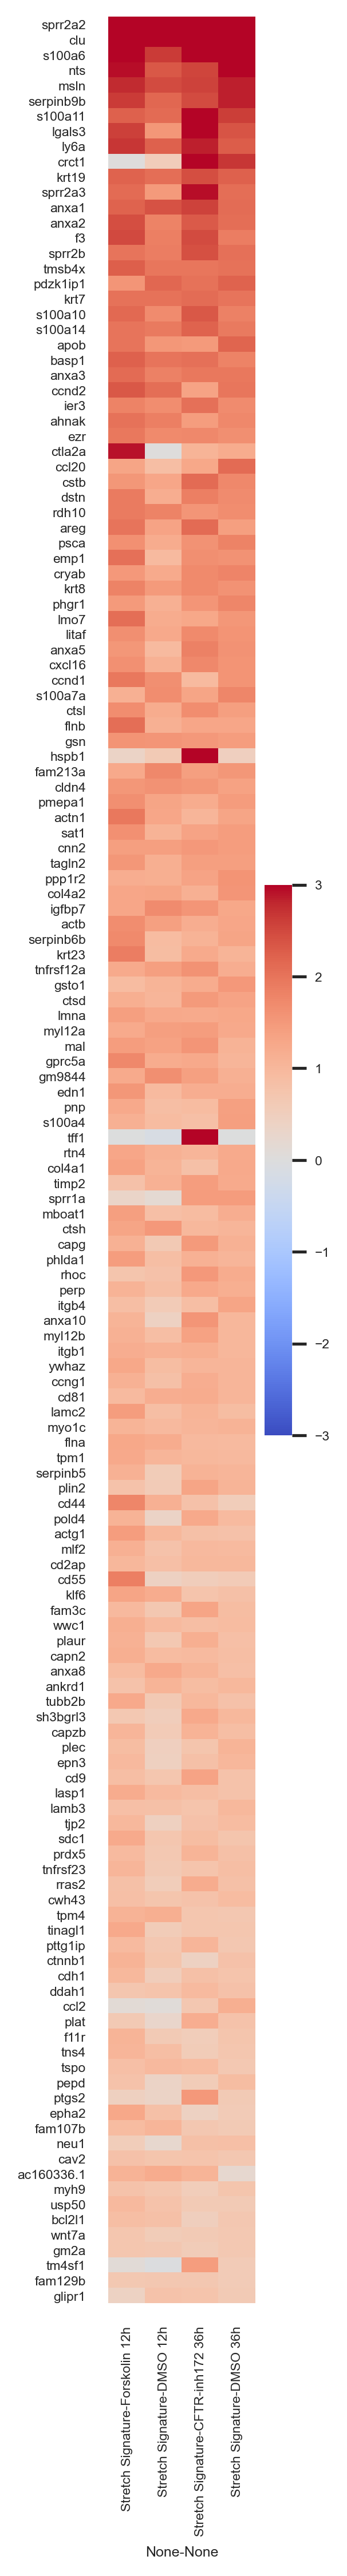

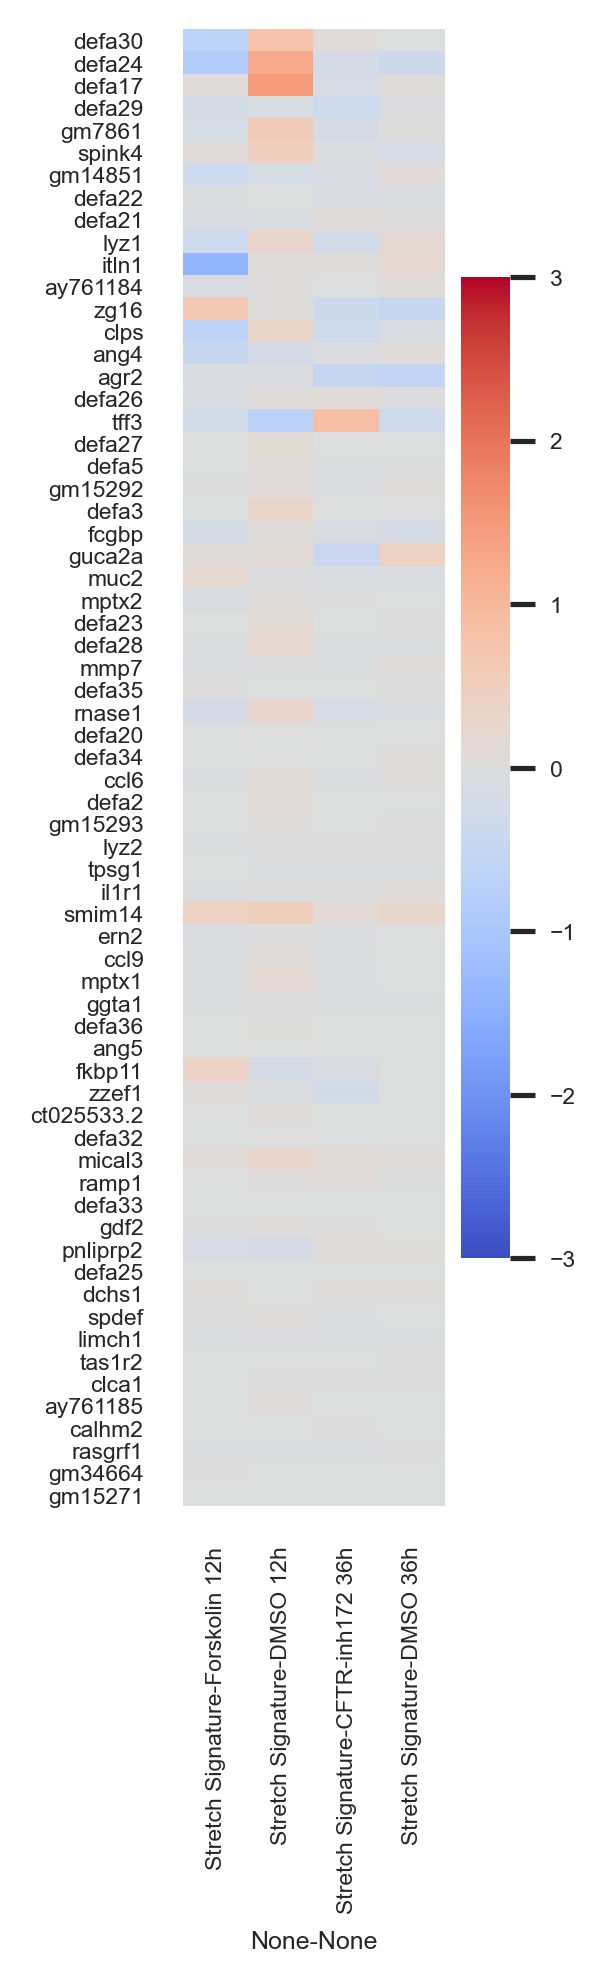

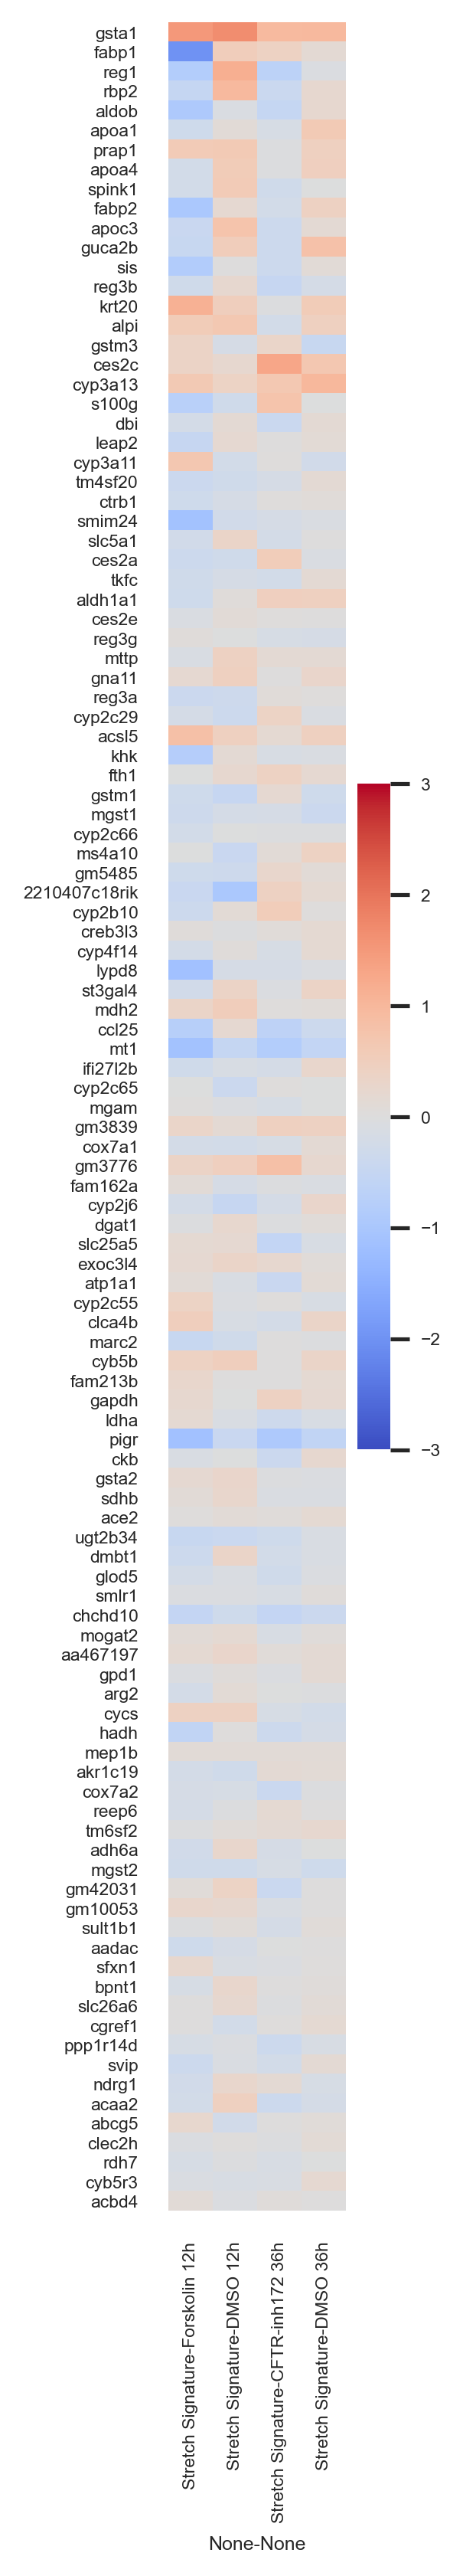

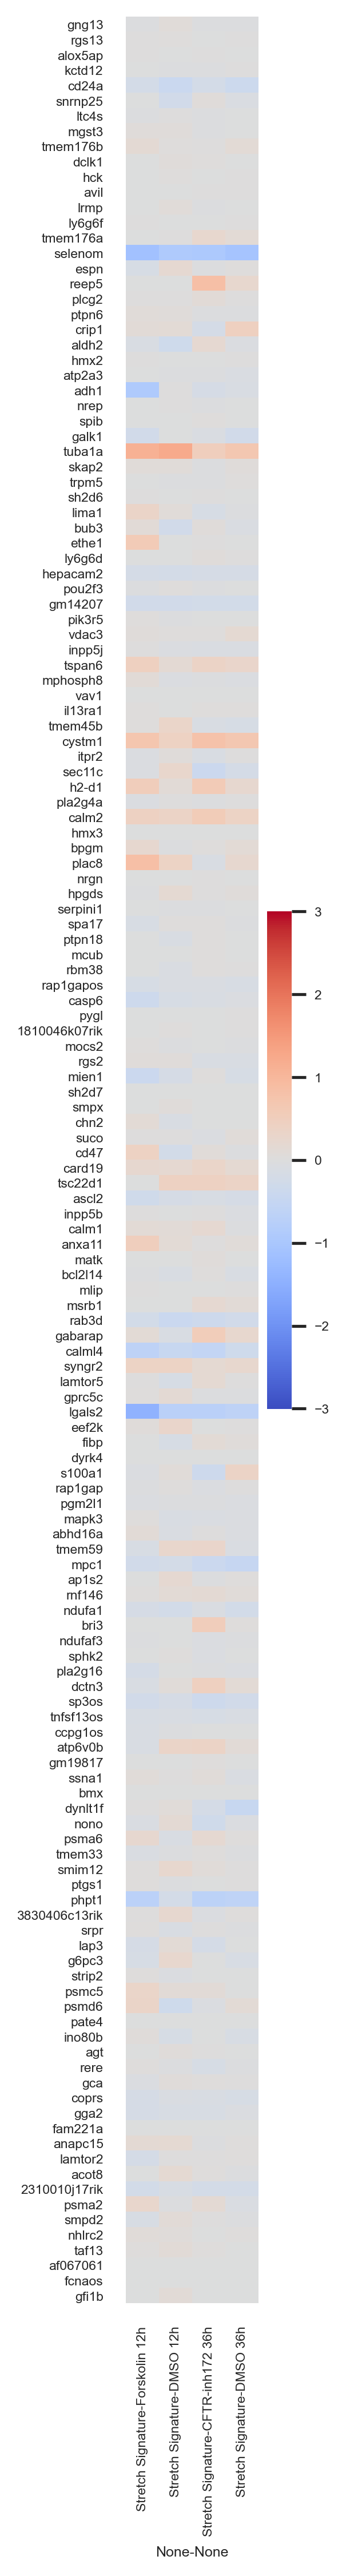

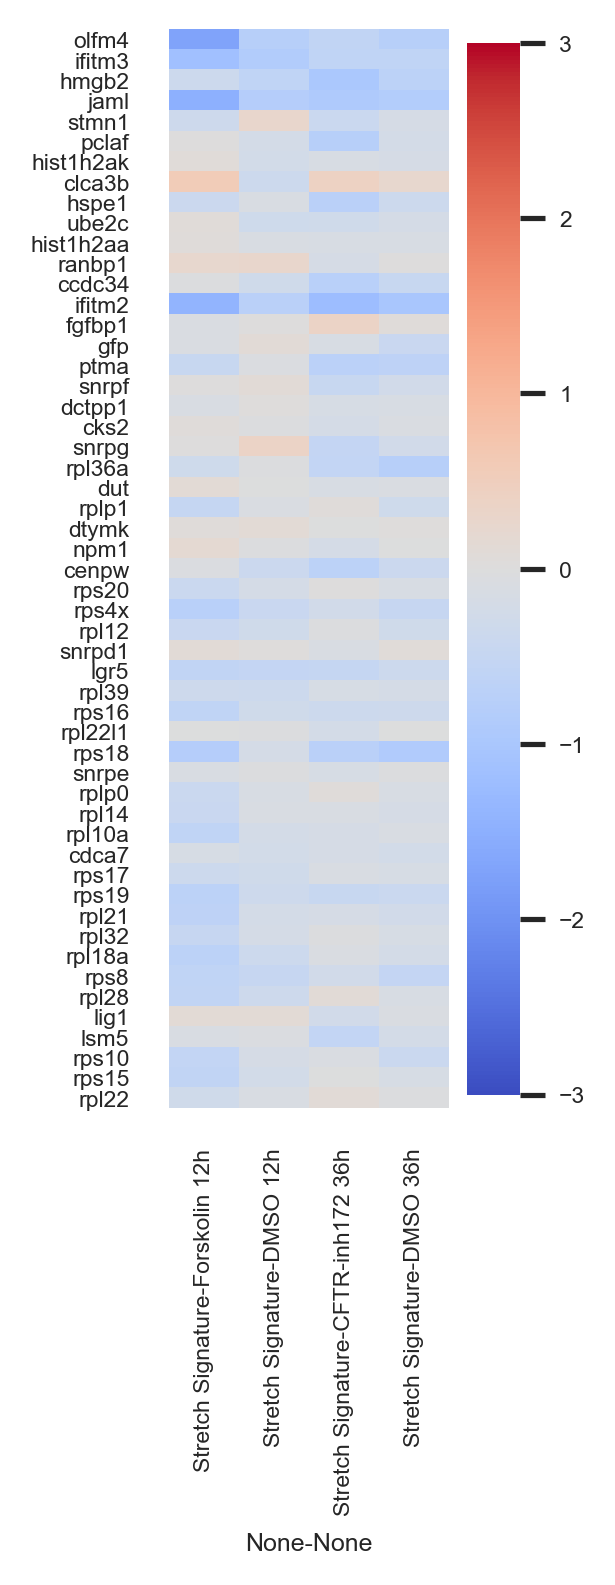

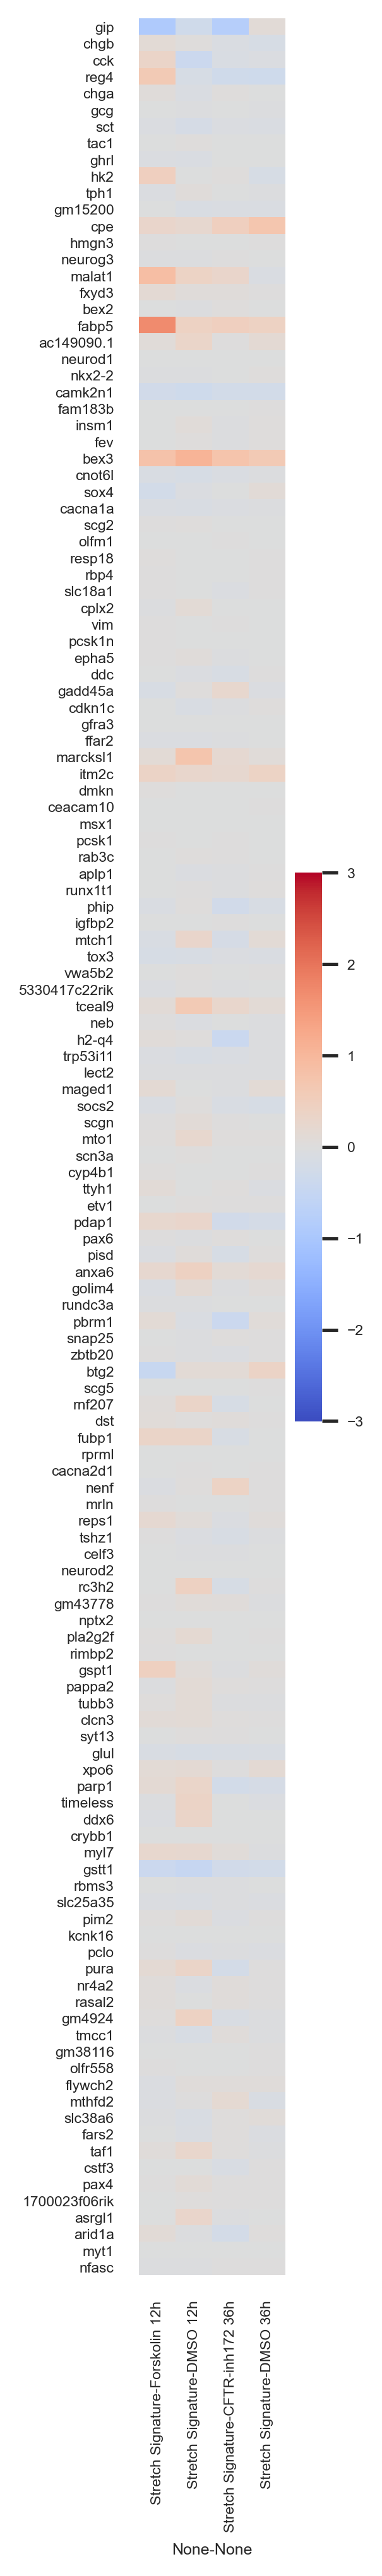

In [22]:
# Now re-make the log fold-change data frame 
#   using same markers, but now for different sets of clusters

# instead of marker genes all - iterate over states, fix vmin vmax, and call 
# logfc marekrs, providing marker genes dict state
# iterate and then save the heatmap every time

# Make and format heatmap:
sns.set(font_scale=0.5)

plot_cell_states = ['Stretch Signature']

new_order_gene_list = []
# The following will generate the plots
for marker_state in marker_genes_dict.keys():
    for gene in marker_genes_dict[marker_state]:
        new_order_gene_list.append(gene)
    plt.figure(figsize = (2,0.1*len(marker_genes_dict[marker_state])) )
    sns.heatmap(logFC_markers[plot_cell_states].loc[marker_genes_dict[marker_state]], cmap='coolwarm',vmin=-3,vmax=+3,xticklabels=1,yticklabels=1)
    plt.tight_layout()
    plt.savefig(f'{plot_dir}/heatmap_genes_by_state_and_condition_perturbations_max150_stretch_sig_cells_only_treat_verbose_{marker_state}_genes.eps')
    plt.show()



#### Save the heatmap data

In [20]:
logFC_markers.to_excel(f'{plot_dir}/LogFC_CP10K_med_CP10K_norm_psct_1_ss_markers_included.xlsx')

#### Save marker gene list

In [23]:
with open('perturbations_mg_list_mg150_treatment_verbose.txt', 'w') as f:
    for gene in new_order_gene_list:
        f.write("%s\n" % gene)